### Homework 01

#### 1)

- Libs usadas

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

- Baixamos inicialmente o dataset de classificação binária de doente e saudável

In [22]:
df = pd.read_csv('./hungarian_heart_diseases.csv')
df

,age,sex,chest_pain,trestbps,fasting_blood_sugar,restecg,thalach,exercise_induce_angina,oldpeak,outcome
0,28,1,2,130,0,2,185,0,0.0,0
1,29,1,2,120,0,0,160,0,0.0,0
2,29,1,2,140,0,0,170,0,0.0,0
3,30,0,1,170,0,1,170,0,0.0,0
4,31,0,2,100,0,1,150,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
279,52,1,4,160,0,0,94,1,2.5,1
280,54,0,3,130,0,1,100,1,0.0,1
281,56,1,4,155,1,0,150,1,3.0,1
282,58,0,2,180,0,0,110,1,1.0,1


Pré processamento:

- Colunas categóricas demandam aplicação de one-hot-encoding -> Não existem neste caso todas são numéricas discretas, exceto old_peak que é numérica continua
- Tratamento de valores faltantes(null values): não existem neste caso também 

Treino/ Teste: 
- Separação do dataset em treino/teste, (80-20) -> enunciado
- Usando seed = 1, p/ reprodutibilidade -> enunciado
- Passei o parâmetro de estratificação como True, p/ garantir a proporção de classes fique preservada, é importante casoa classificação entre classes esteja desbalanceada, não chega a ser o caso (63.73% - 36.27%)
- Usando a quantidades de samples {1,3,5,10,25,50,100}, vamos treinar nossa decision tree
- Calculamos a acurácia, o recall dessas 

In [23]:
y = df['outcome'].copy()
X = df.drop(columns=['outcome']).copy()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1
)

leaf_values = [1, 3, 5, 10, 25, 50, 100]
results = []
for leaf in leaf_values:
    clf = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=1)
    clf.fit(X_train, y_train)
    results.append({
        'min_samples_leaf': leaf,
        'train_accuracy': clf.score(X_train, y_train),
        'test_accuracy': clf.score(X_test, y_test),
    })

res_df = pd.DataFrame(results)
print(res_df)

   min_samples_leaf  train_accuracy  test_accuracy
0                 1        1.000000       0.771930
1                 3        0.907489       0.789474
2                 5        0.859031       0.807018
3                10        0.837004       0.807018
4                25        0.810573       0.859649
5                50        0.801762       0.719298
6               100        0.638767       0.631579


- Comparando as acurácias dos datasets de treino/test em formato gráfico

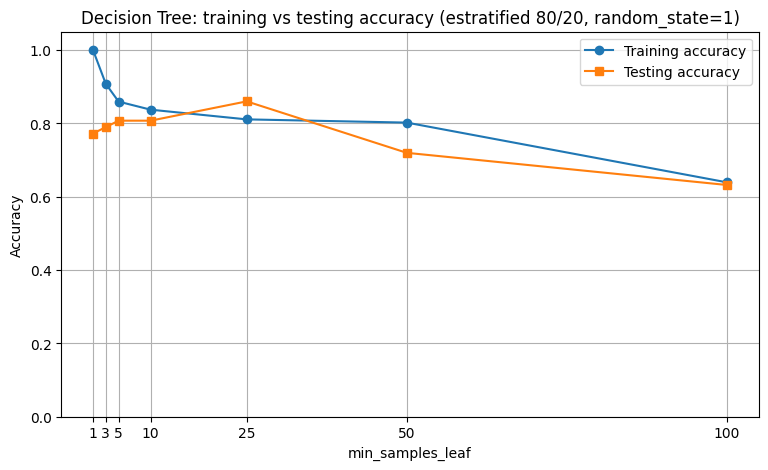

In [24]:
plt.figure(figsize=(9,5))
plt.plot(res_df['min_samples_leaf'], res_df['train_accuracy'], marker='o', label='Training accuracy')
plt.plot(res_df['min_samples_leaf'], res_df['test_accuracy'], marker='s', label='Testing accuracy')
plt.xticks(res_df['min_samples_leaf'])
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Decision Tree: training vs testing accuracy (estratified 80/20, random_state=1)')
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.legend()
plt.show()

#### 2) 

- Fazendo uma análise crítica sobre podemos observar em que quanto menos observações há, mais o modelo se torna muito específico, ou seja, no qual se observa o overfiting natural por conta deste processo de extrema especificidade, visto que, isso é demonstrado pela baixa acurácia do dataset de teste 

- Agora no caso de uma amostragem extremamente grande, acontece o underfiting, visto que o modelo fica extremamente generalista e acaba generalizando até demais que pode levar a alucinações, por exemplo, explicando assim a baixa acurácia da sample quando é 100, tanto em teste quanto em treino

- Os melhores resultados ficaram por conta das samples de 10 e 25, principalmente da de 25, que não ficou nem over nem underfitada, em que teve uma boa capacidade de generalizar, e principalmente a de 25 que tem uma base de dados mais considerável apresnetou resultados muito bons , tanto em treino quanto em teste

### 3)

- Carregamos o dataset novamente a fim de evitar qualquer tipo de modificação realizada sobre ele

In [25]:
df = pd.read_csv('./hungarian_heart_diseases.csv')
y = df['outcome'].copy()
X = df.drop(columns=['outcome']).copy()

Dividimos o dataset:
- (60/20/20), (treino/teste/validação) -> como enunciado solicita

In [26]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=1
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=1
)

print(f"Quantidade de entidades: treino={len(y_train)}, val={len(y_val)}, teste={len(y_test)}")

Quantidade de entidades: treino=170, val=57, teste=57


- Afim de atingir a acurácia desejada, precisamos buscar uma boa combinação de hiperparâmetros que faça sentido para a nossa distribuição de dataset atual
- Testamos as seguintes combinações

    1) max_depth ∈ {2, 3, 4}
    2) min_samples_split ∈ {2, …, 100}

- Para cada uma dessas combinações que serão feitas no loop, guardamos no array os resultados da acurácia, dado treino -> teste -> validação
- Lembrando que nossos candidatos tem que satisfazer: 80% acc p/ treino e 78.5% p/ teste

In [27]:
best_model = None
results = []

for depth in [2, 3, 4]:
    for min_split in range(2, 101):
        clf = DecisionTreeClassifier(
            max_depth=depth, min_samples_split=min_split, random_state=1
        )
        clf.fit(X_train, y_train)
        train_acc = clf.score(X_train, y_train)
        val_acc = clf.score(X_val, y_val)
        test_acc = clf.score(X_test, y_test)

        results.append((depth, min_split, train_acc, val_acc, test_acc))

        if val_acc >= 0.80 and test_acc >= 0.785:
            if best_model is None or clf.score(X_val, y_val) > best_model.score(X_val, y_val):
                best_model = clf
            elif val_acc == best_model.score(X_val, y_val):
                if clf.score(X_test, y_test) > best_model.score(X_test, y_test):
                    best_model = clf
            elif val_acc == best_model.score(X_val, y_val) and test_acc == best_model.score(X_test, y_test):
                if clf.score(X_train, y_train) > best_model.score(X_train, y_train):
                    best_model = clf
            elif val_acc == best_model.score(X_val, y_val) and test_acc == best_model.score(X_test, y_test) and clf.score(X_train, y_train) == best_model.score(X_train, y_train):
                if depth < best_model.get_depth():
                    best_model = clf
            elif val_acc == best_model.score(X_val, y_val) and test_acc == best_model.score(X_test, y_test) and clf.score(X_train, y_train) == best_model.score(X_train, y_train) and depth == best_model.get_depth():
                if min_split > best_model.min_samples_split:
                    best_model = clf

- Dada essa lista de candidatos p/ realizarmos uma determinada escolha, poderíamos nos basear em alguns critérios, como: maior valor de acurácia na validação, idem para o teste, o que tem menor profundidade, etc
- O critério que adotei foi escolher aquele que apresenta-se a melhor acurácia quanto a validação, sempre satisfazendo os critérios mínimos estabelecidos pelo enunciado
- Caso aconteça um empate, o que existe uma probalidade real, visto que o dataset é pequeno, iremos usar como desempate, melhor acc em teste, melhor acc em treino, menor profundidade, melhor acurácia em teste e por último maior número de samples 

In [28]:
res_df = pd.DataFrame(results, columns=["depth","min_split","train","val","test"])
print(res_df.sort_values("val", ascending=False).head())

if best_model:
    print("Modelo escolhido:", best_model)
else:
    print("Nenhum modelo atingiu os requisitos.")

     depth  min_split     train       val      test
211      4         15  0.876471  0.807018  0.789474
207      4         11  0.876471  0.807018  0.789474
212      4         16  0.876471  0.807018  0.789474
213      4         17  0.876471  0.807018  0.789474
214      4         18  0.876471  0.807018  0.789474
Modelo escolhido: DecisionTreeClassifier(max_depth=4, min_samples_split=11, random_state=1)


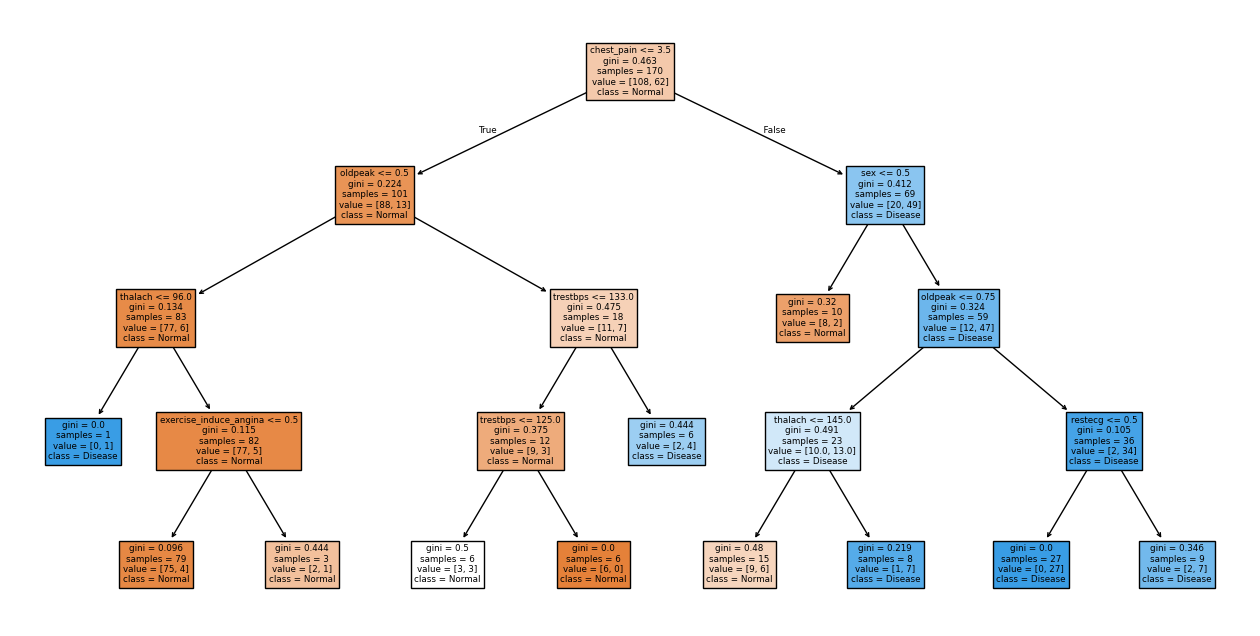

|--- chest_pain <= 3.50
|   |--- oldpeak <= 0.50
|   |   |--- thalach <= 96.00
|   |   |   |--- class: 1
|   |   |--- thalach >  96.00
|   |   |   |--- exercise_induce_angina <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- exercise_induce_angina >  0.50
|   |   |   |   |--- class: 0
|   |--- oldpeak >  0.50
|   |   |--- trestbps <= 133.00
|   |   |   |--- trestbps <= 125.00
|   |   |   |   |--- class: 0
|   |   |   |--- trestbps >  125.00
|   |   |   |   |--- class: 0
|   |   |--- trestbps >  133.00
|   |   |   |--- class: 1
|--- chest_pain >  3.50
|   |--- sex <= 0.50
|   |   |--- class: 0
|   |--- sex >  0.50
|   |   |--- oldpeak <= 0.75
|   |   |   |--- thalach <= 145.00
|   |   |   |   |--- class: 0
|   |   |   |--- thalach >  145.00
|   |   |   |   |--- class: 1
|   |   |--- oldpeak >  0.75
|   |   |   |--- restecg <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- restecg >  0.50
|   |   |   |   |--- class: 1



In [29]:
plt.figure(figsize=(16,8))
plot_tree(best_model, feature_names=X.columns, class_names=["Normal","Disease"], filled=True)
plt.show()

from sklearn import tree
text_rules = tree.export_text(best_model, feature_names=list(X.columns))
print(text_rules)